## Week 11 Solution to Application 2: carbon fiber reinforced Al

#### Load packages

In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from scipy import ndimage
from skimage import io, color, measure
import pandas as pd

from PIL import Image
from IPython.display import display

from pathlib import Path

In [2]:
#img = cv.imread("grains callister.png")
#img=img[8:270, 10:230]
imgfull=cv.imread('../../images/Carbon fiber in Al matrix.jpg')
img=imgfull[0:270, :]
img=cv.cvtColor(img,cv.COLOR_BGR2RGB)
img_shift=cv.pyrMeanShiftFiltering(img, 7, 11)  #acts on original image
#img_shift=img
gray=cv.cvtColor(img_shift,cv.COLOR_BGR2GRAY) #move img to gray scale
blur=cv.GaussianBlur(gray,(3,3),0) # acts on gray scale image

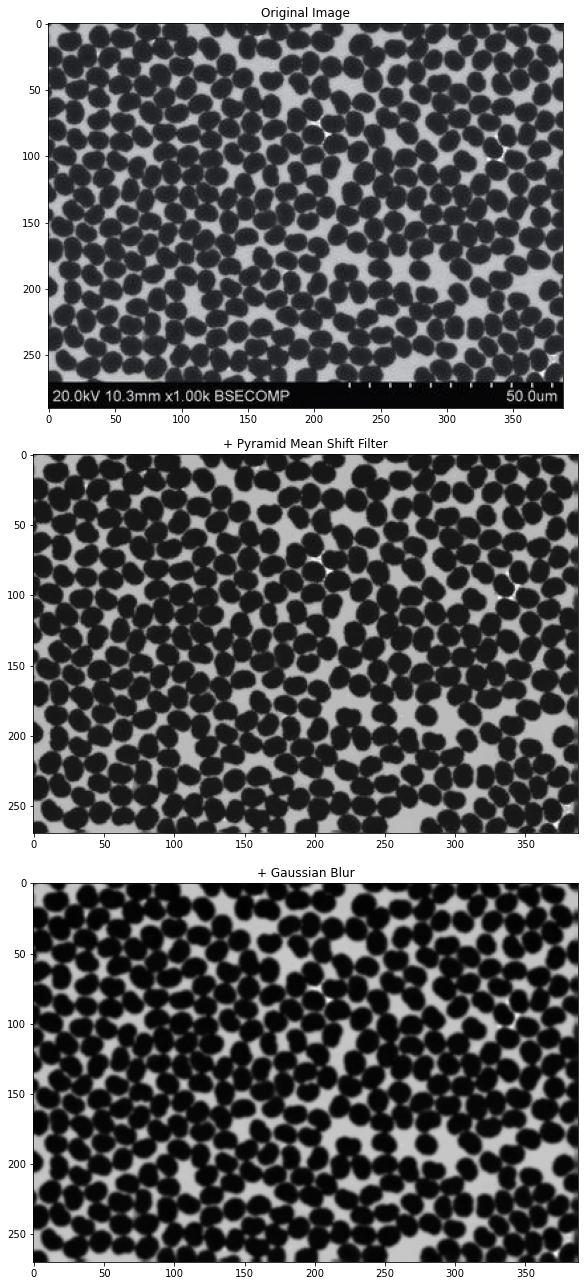

In [3]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1,figsize=(8, 18))
ax1.imshow(imgfull)
ax2.imshow(gray, cmap='gray')
ax3.imshow(blur, cmap='gray')
ax1.set_title('Original Image')
ax2.set_title('+ Pyramid Mean Shift Filter')
ax3.set_title('+ Gaussian Blur')
plt.tight_layout()

#### Now threshold our image to black (0) & white (255) 

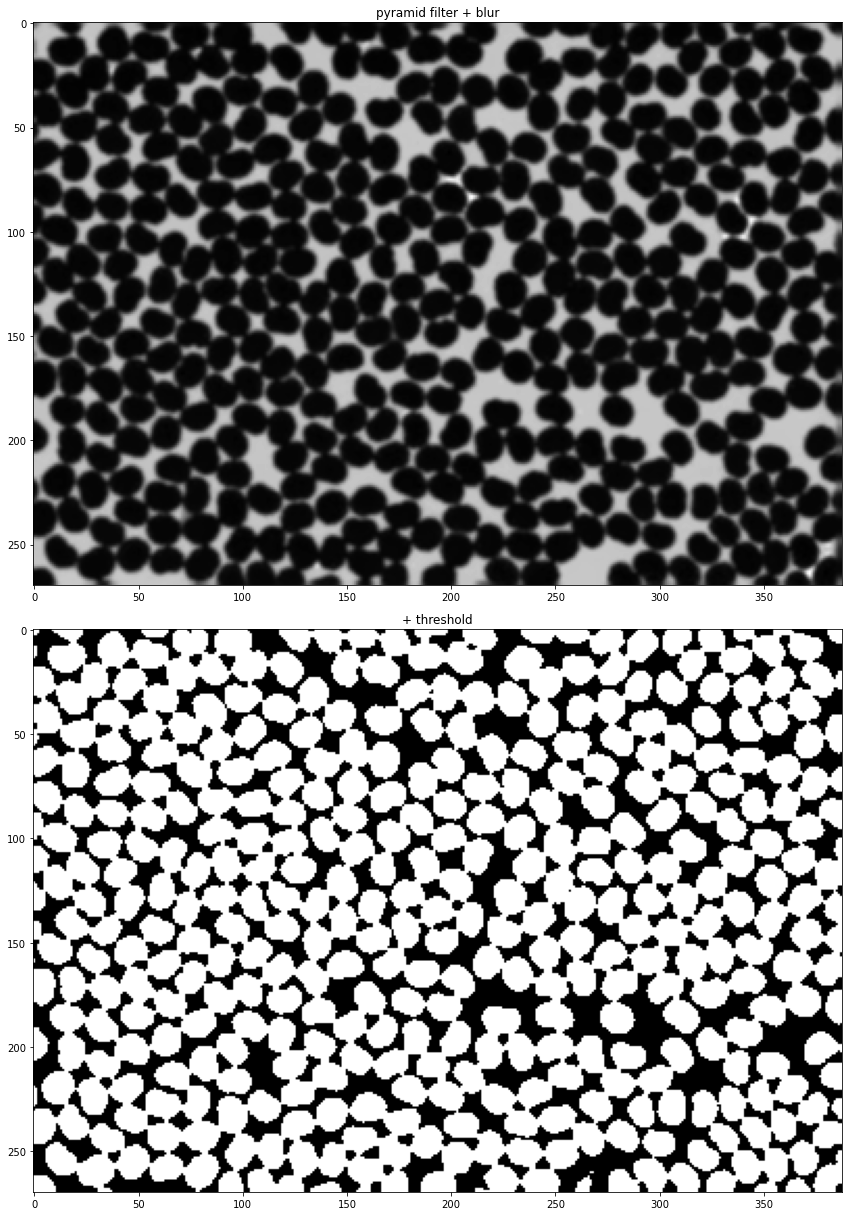

In [4]:
image_to_threshold=blur

#************** 3 choices here for performing threshold *********************
#ret, thresh = cv.threshold(image_to_threshold,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
#ret, thresh = cv.threshold(image_to_threshold,50,255,cv.THRESH_BINARY)
thresh= cv.adaptiveThreshold(image_to_threshold, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY_INV, 17, 0)
#thresh = cv.adaptiveThreshold(image_to_threshold,220,cv.ADAPTIVE_THRESH_MEAN_C,cv.THRESH_BINARY,11,5) # notice using gray here not img

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1,figsize=(14, 17))
ax1.imshow(blur, cmap='gray')
ax2.imshow(thresh, cmap='gray')
ax1.set_title('pyramid filter + blur')
ax2.set_title('+ threshold')

plt.tight_layout()

#### Now define a few images we  need to apply our watershed routine. 

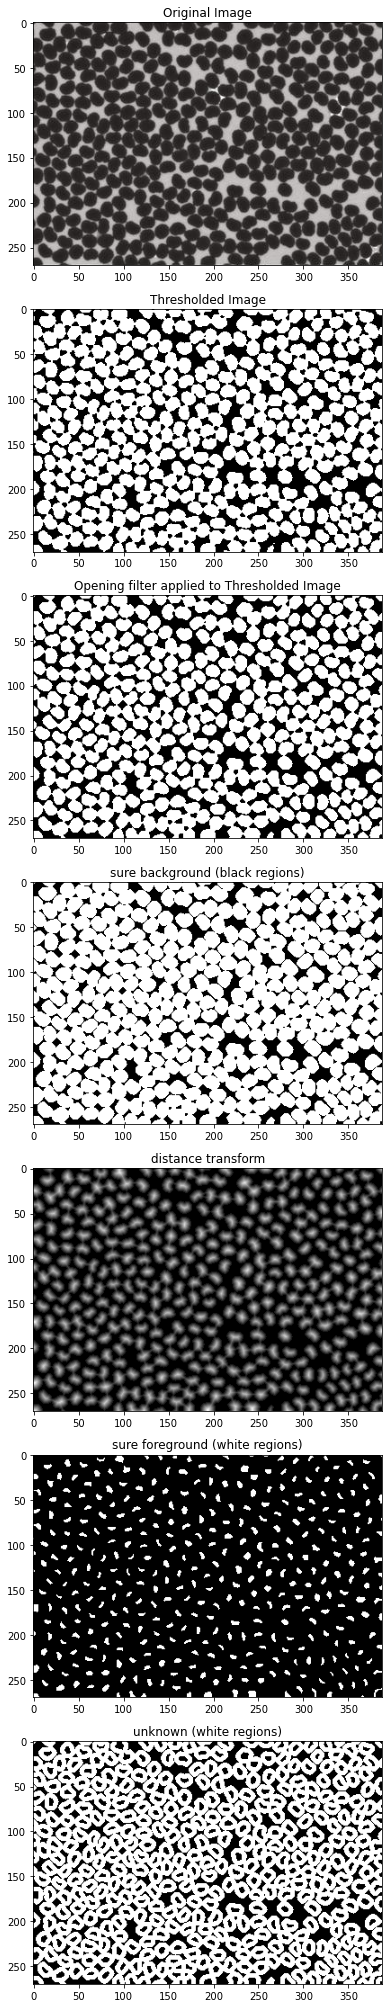

In [5]:
kernel=cv.getStructuringElement(cv.MORPH_CROSS,(3,3))
#kernel=cv.getStructuringElement(cv.MORPH_ELLIPSE,(3,3))
# kernel=cv.getStructuringElement(cv.MORPH_RECT,(3,3))

# noise removal
opening = cv.morphologyEx(thresh,cv.MORPH_OPEN,kernel, iterations=2)

# sure background area
#sure_bg = cv.dilate(opening,kernel,iterations=2)

bgt = cv.dilate(opening,kernel,iterations = 1)
#ret,sure_bg = cv.threshold(bgt,1,128,1)

sure_bg=bgt

# Finding sure foreground area
sure_fg = cv.erode(opening,kernel,iterations=3)

# Finding sure foreground area
dist_transform = cv.distanceTransform(opening,cv.DIST_L2,5)
ret, sure_fg = cv.threshold(dist_transform,0.5*dist_transform.max(),255,0)
sure_fg = np.uint8(sure_fg)

# Finding unknown region
unknown = cv.subtract(sure_bg,sure_fg)
#unknown=cv.add(sure_fg,sure_bg)


# ******************* Display results of each step ********************

fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(nrows=7, ncols=1,figsize=(8, 28))
ax1.imshow(img, cmap='gray')
ax2.imshow(thresh, cmap='gray')
ax3.imshow(opening, cmap='gray')
ax4.imshow(sure_bg, cmap='gray')
ax5.imshow(dist_transform, cmap='gray')
ax6.imshow(sure_fg, cmap='gray')
ax7.imshow(unknown, cmap='gray')

ax1.set_title('Original Image')
ax2.set_title('Thresholded Image')
ax3.set_title('Opening filter applied to Thresholded Image')
ax4.set_title('sure background (black regions)')
ax5.set_title('distance transform')
ax6.set_title('sure foreground (white regions)')
ax7.set_title('unknown (white regions)')
plt.tight_layout()

In [6]:
unknown

array([[255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ..., 255,   0,   0],
       [255, 255,   0, ..., 255, 255,   0],
       ...,
       [  0,   0,   0, ..., 255,   0,   0],
       [  0,   0,   0, ..., 255,   0,   0],
       [  0,   0,   0, ..., 255,   0,   0]], dtype=uint8)

#### Label groups of connected pixels with integers (labels)

In [7]:
# Marker labelling
# cv2.connectedComponents(). labels background of the image with 0, 
#then other objects are labelled with integers starting from 1.
ret, markers = cv.connectedComponents(sure_fg)
# bw_unknown=unknown
# bw_unknown[bw_unknown==128]=0
# ret, markers = cv.connectedComponents(bw_unknown)
# marker1=markers

In [8]:
markers

array([[  0,   0,   0, ...,  14,  14,  14],
       [  0,   0,   0, ...,   0,  14,  14],
       [  0,   0,   0, ...,   0,   0,  14],
       ...,
       [377, 377, 377, ...,   0,   0,   0],
       [377, 377, 377, ...,   0,   0,   0],
       [377, 377, 377, ...,   0,   0,   0]], dtype=int32)

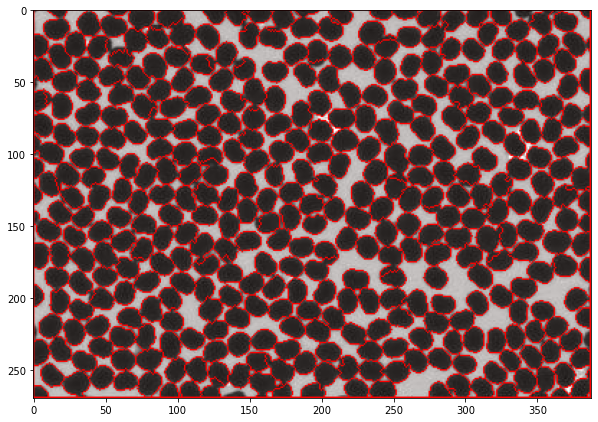

In [9]:
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0

markers = cv.watershed(img,markers)  # img needs shape (pix, pix, 3), markers is (pix, pix)

img[markers ==-1] = [255,0,0]

#display(Image.fromarray(markers))
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111) # 1x1 grid, first subplot

ax.imshow(img)

plt.show()


#### Change the marker labels to colors and combine with the original image

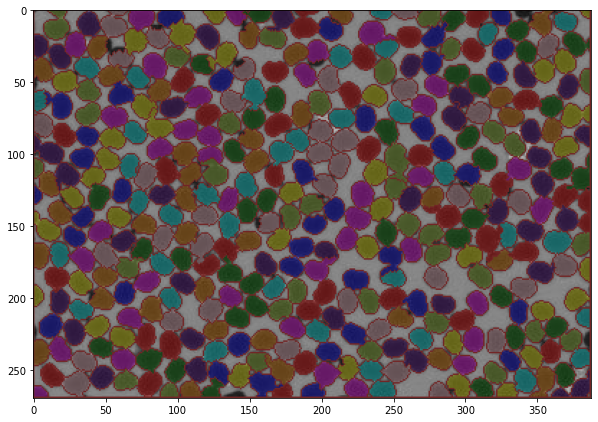

In [34]:
img2=color.label2rgb(markers, image=img, bg_label=1, alpha=0.3)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111) # 1x1 grid, first subplot
ax.imshow(img2, aspect='equal');
plt.show()

#### Each colored grain can now be analyzed and placed in a Pandas DataFrame

In [19]:
pixels_to_μm=.5  # μm per pixel
propList=['label','eccentricity','centroid','area','equivalent_diameter','orientation','major_axis_length', 'minor_axis_length','perimeter']
#propList=['equivalent_diameter','orientation','area','major_axis_length']
props=measure.regionprops_table(markers, properties=propList)

grain_data=pd.DataFrame(props)

grain_data.head()

label  eccentricity  centroid-0  centroid-1   area  equivalent_diameter  \
0      1      0.700545  135.115733  200.105716  26155           182.487206   
1      3      0.812890    5.251656   94.675497    151            13.865755   
2      4      0.745814    4.244898  126.510204     98            11.170384   
3      5      0.666427    4.822917  140.718750     96            11.055813   
4      6      0.873367    4.061947  156.752212    113            11.994835   

   orientation  major_axis_length  minor_axis_length     perimeter  
0    -1.566343         443.793078         316.694274  13216.040108  
1    -1.394776          18.542521          10.799496     49.455844  
2     1.431267          14.285359           9.516254     38.970563  
3     1.200379          13.138267           9.795504     38.384776  
4     1.541039          17.969894           8.752458     45.798990

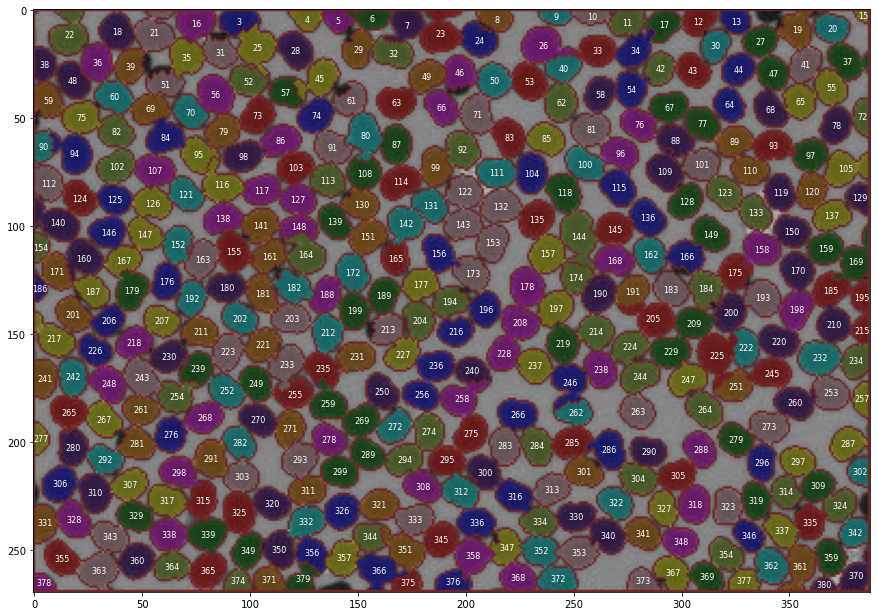

In [27]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111) # 1x1 grid, first subplot
ax.imshow(img2, aspect='equal');
[ax.annotate(f'{label:0.0f}', xy=(posx, posy), c='white',fontsize=8, horizontalalignment='center', verticalalignment='center') for label, posx, posy in np.array(grain_data.loc[1:,['label','centroid-1','centroid-0']])]

plt.show()

In [31]:
# angle relative to the vertical
tt=grain_data[grain_data['label']==18]
print(*tt['orientation']*180/np.pi)
tt

18.98864362658626


label  eccentricity  centroid-0  centroid-1  area  equivalent_diameter  \
15     18      0.519929    9.927835   38.381443   194            15.716503   

    orientation  major_axis_length  minor_axis_length  perimeter  
15     0.331414          17.142128           14.64297  53.112698

<AxesSubplot:>

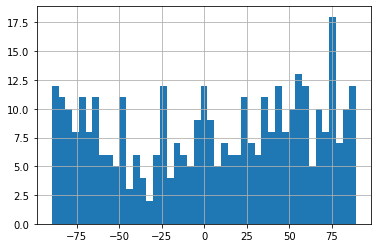

In [37]:
(grain_data['orientation']*180/np.pi).hist(bins=45)

In [23]:
#number of particles
len(grain_data.loc[1:, 'label'])

375

<AxesSubplot:>

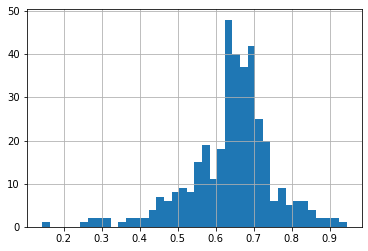

In [24]:
# when eccentricity = 0 the ellipse becomes a circle
grain_data.loc[1:, 'eccentricity'].hist(bins=40)

<AxesSubplot:>

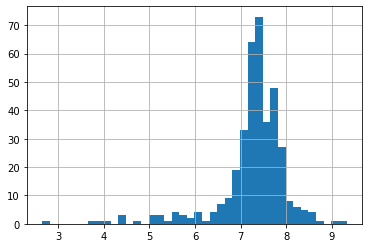

In [25]:
(grain_data.loc[1:, 'equivalent_diameter']*pixels_to_μm).hist(bins=40)

In [26]:
background_pix=len(markers[markers==1])
interface_pix=len(markers[markers==-1])
particles_pix=len(markers[markers>1])
total_pix=background_pix+interface_pix+particles_pix

print(f'total pixels = {total_pix}')
print(f'interface % = {interface_pix/total_pix*100:0.1f}%')
#giving half of the interface pixels to background and half to proeutectoid ferrite: 
print('Give half of the interface pixs to each of the following:')
print(f'background % = {(background_pix+interface_pix/2)/total_pix*100:0.1f}%')
print(f'particles % = {(particles_pix+interface_pix/2)/total_pix*100:0.1f}%')

mean_particle=(grain_data.loc[1:,'equivalent_diameter']*pixels_to_μm).mean()
print(f'avg particle diameter = {mean_particle}')

total pixels = 104760
interface % = 15.0%
Give half of the interface pixs to each of the following:
background % = 32.5%
particles % = 67.5%
avg particle diameter = 7.267267867159093


Playing around to change color of fibers according to eccentricity

In [62]:
ttt=grain_data[(grain_data['eccentricity']>0.6) & (grain_data['eccentricity']<0.7)]['label'].values
marker_2=markers
print(ttt)
marker_2[(marker_2==142) | (marker_2==174)| (marker_2==214)| (marker_2==358)]=0

[  5  13  16  20  22  24  26  28  30  31  33  39  40  41  43  49  52  53
  57  58  59  60  61  63  66  67  69  70  71  73  74  76  77  78  79  83
  85  87  88  89  91  94  96  99 102 104 107 110 111 112 116 117 118 119
 120 121 123 124 126 127 128 129 130 131 133 136 137 138 143 147 149 151
 153 155 166 168 172 173 176 179 180 182 185 189 190 192 194 197 198 201
 202 203 206 207 208 209 211 212 216 218 219 220 225 226 227 229 230 231
 232 234 236 238 247 248 249 250 256 260 261 264 266 267 269 270 271 273
 274 275 278 280 282 283 284 286 287 288 289 290 292 294 295 299 300 302
 304 305 307 308 310 312 313 317 319 320 321 322 323 327 328 329 332 333
 334 336 340 341 347 349 353 354 355 356 357 359 364 365 366 368 369]


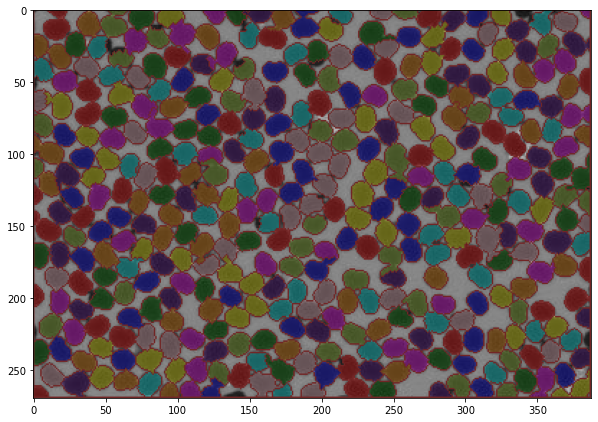

In [60]:
img3=color.label2rgb(marker_2, image=img, bg_label=1, alpha=0.3)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111) # 1x1 grid, first subplot
ax.imshow(img3, aspect='equal');
plt.show()